In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
parent_dir = 'C:\\Users\\hp\\Desktop\\data'
files = ['akshay1.csv', 'akshay2.csv', 'akshay3.csv', 'Chaitanya1.csv', 'Chaitanya2.csv', 'Chaitanya3.csv',
         'Hitarth1.csv', 'Hitarth2.csv', 'Hitarth3.csv', 'shivang51.csv', 'shivang52.csv', 'shivang53.csv',
         'shruti1.csv', 'sparsh1.csv', 'sparsh2.csv', 'sparsh3.csv']
cols = ['Output1', 'Output2', 'Output3', 'Output4', 'var1', 'var2', 'var3', 'var4']
final_df = []
st_ind = ['start zero.png', 'start one.png', 'start two.jpg', 'start three.jpg', 'start four.jpg',
          'start five.jpg', 'start six.jpg', 'start seven.jpg', 'start eight.jpg', 'start nine.jpg', 'start animal.jpg']
end_ind = ['end zero.png', 'end one.png', 'end two.jpg', 'end three.jpg', 'end four.jpg',
           'end five.jpg', 'end six.jpg', 'end seven.jpg', 'end eight.jpg', 'end nine.jpg', 'end animal.jpg']


In [3]:
image_mapping = {
    'start zero.png': 0, 'start one.png': 1, 'start two.jpg': 2, 'start three.jpg': 3, 'start four.jpg': 4,
    'start five.jpg': 5, 'start six.jpg': 6, 'start seven.jpg': 7, 'start eight.jpg': 8, 'start nine.jpg': 9,
    'start animal.jpg': -1
}

In [4]:
for name in files:
    file_path = os.path.join(parent_dir, name)
    df = pd.read_csv(file_path)
    df.columns = cols
    df = df.drop(cols[4:], axis=1)
    final_df1 = []

    for a, b in zip(st_ind, end_ind):
        start_idx = df[df['Output1'] == a].index
        end_idx = df[df['Output1'] == b].index
        temp_df1 = []

        for i, j in zip(start_idx, end_idx):
            row = df.iloc[i + 1:j]
            temp_df1.append(row)

        merged_df1 = pd.concat(temp_df1, ignore_index=True, sort=False)
        merged_df1 = merged_df1.reset_index(drop=True)
        final_df.append(merged_df1)

lengths = [len(a) for a in final_df]
med = int(np.median(lengths))

In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.fft import fft
import scipy.signal as signal

# Resample array function
def resample_array(array, target_length):
    input_indices = np.linspace(0, len(array) - 1, len(array))
    resampled_indices = np.linspace(0, len(array) - 1, target_length)
    interpolator = interp1d(input_indices, array, kind='linear')
    return interpolator(resampled_indices)

# Euclidean normalization function
def euclidean_normalize(data):
    norm = np.linalg.norm(data, axis=1, keepdims=True)
    return data / norm

# Data augmentation functions
def add_noise(data, noise_factor=0.05):
    noise = np.random.randn(*data.shape)
    augmented_data = data + noise_factor * noise
    return augmented_data

def scale_data(data, scale_factor=1.2):
    return data * scale_factor

def shift_data(data, shift_max=0.2):
    shift_amount = int(shift_max * data.shape[1])
    if shift_amount > 0:
        shift = np.random.randint(low=-shift_amount, high=shift_amount)
    else:
        shift = 0
    return np.roll(data, shift, axis=1)

def bandstop_filter(data, lowcut=49, highcut=51, fs=256, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(b, a, data, axis=1)
    return y

def frequency_shift(data, shift=1, fs=256):
    f = np.fft.rfftfreq(data.shape[1], d=1/fs)
    Y = np.fft.rfft(data, axis=1)
    Y_shifted = np.roll(Y, shift, axis=1)
    return np.fft.irfft(Y_shifted, n=data.shape[1], axis=1)

def smooth_time_mask(data, mask_factor=0.1, mask_size=50):
    mask = np.ones(data.shape[1])
    num_masks = int(mask_factor * data.shape[1] / mask_size)
    for _ in range(num_masks):
        mask_start = np.random.randint(0, data.shape[1] - mask_size)
        mask[mask_start:mask_start + mask_size] = 0
    return data * mask

# Resampling and normalization
resampled_data = []
target_var = []
for i, dff in enumerate(final_df):
    resampled_segment = {}
    for col in cols[:4]:
        val = dff[col].values
        resampled_segment[col] = resample_array(val, med)
    resampled_data.append(pd.DataFrame(resampled_segment))
    target_var.append(image_mapping[st_ind[i % len(st_ind)]])

# Normalize the resampled data
normalized_data = [euclidean_normalize(segment.values) for segment in resampled_data]

# Data augmentation
X_augmented = []
y_augmented = []
xcheck = []
ycheck = []

for i in range(len(normalized_data)):
    segment = normalized_data[i]
    X_augmented.append(segment)
    xcheck.append(segment)
    ycheck.append(target_var[i])
    y_augmented.append(target_var[i])
    X_augmented.append(add_noise(segment))
    y_augmented.append(target_var[i])
    X_augmented.append(scale_data(segment))
    y_augmented.append(target_var[i])
    X_augmented.append(shift_data(segment))
    y_augmented.append(target_var[i])
    X_augmented.append(bandstop_filter(segment))
    y_augmented.append(target_var[i])
    X_augmented.append(frequency_shift(segment))
    y_augmented.append(target_var[i])
    X_augmented.append(smooth_time_mask(segment))
    y_augmented.append(target_var[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)
xcheck = np.array(xcheck)
ycheck = np.array(ycheck)

def apply_fft(segment):
    fft_features = []
    for col in range(segment.shape[1]):
        fft_vals = np.abs(fft(segment[:, col]))[:med // 2]
        fft_features.extend(fft_vals)
    return fft_features

X_fft = np.array([apply_fft(segment) for segment in X_augmented])
y_fft = np.array(y_augmented)

xcheck = np.array([apply_fft(segment) for segment in xcheck])
ycheck = np.array(ycheck)

In [6]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_fft)
y_categorical = to_categorical(y_encoded)
ycheck_encoded = encoder.fit_transform(ycheck)
ycheck_categorical = to_categorical(ycheck_encoded)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_fft, y_categorical, test_size=0.2, random_state=42)

In [8]:
print(X_train[0])

[1.21024613e+03 3.37157626e-01 1.66775422e-01 ... 7.45006713e-04
 7.42674484e-04 7.35765016e-04]


In [9]:
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
xcheck = xcheck.reshape(xcheck.shape[0], xcheck.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)

(985, 2560)
(985, 2560, 1)


In [10]:
y_train.shape

(985, 11)

In [11]:
xcheck.shape

(176, 2560, 1)

In [12]:
model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())  
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())  
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.BatchNormalization()) 
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization()) 
model.add(layers.Dense(y_categorical.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2558, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2558, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1279, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1277, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1277, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 638, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 636, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 636, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 318, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 81408)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,420,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,547,595 (40.24 MB)

 Trainable params: 10,546,443 (40.23 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [13]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks = early_stopping)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.0876 - loss: 3.0620 - val_accuracy: 0.0810 - val_loss: 3.4943
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.0742 - loss: 2.5121 - val_accuracy: 0.0769 - val_loss: 3.0891
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 425ms/step - accuracy: 0.1077 - loss: 2.4295 - val_accuracy: 0.0850 - val_loss: 2.7245
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.0919 - loss: 2.4168 - val_accuracy: 0.0769 - val_loss: 6.0905
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.1197 - loss: 2.3926 - val_accuracy: 0.0769 - val_loss: 2.9159
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - accuracy: 0.1017 - loss: 2.4333 - val_accuracy: 0.0769 - val_loss: 3.2064
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 401ms/step - accuracy: 0.1352 - loss: 2.3910 - val_accuracy: 0.0729 - val_loss: 3.0638
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.1919 - loss: 2.2978 - 

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7881 - loss: 1.2865
Test Accuracy: 0.7935


In [15]:
loss, accuracy = model.evaluate(xcheck, ycheck_categorical)
print(f"Test Accuracy: {accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0062
Test Accuracy: 1.0000


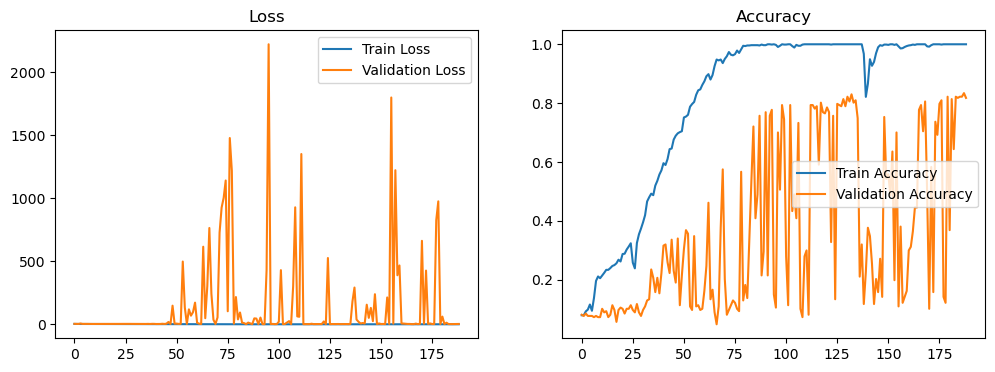

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

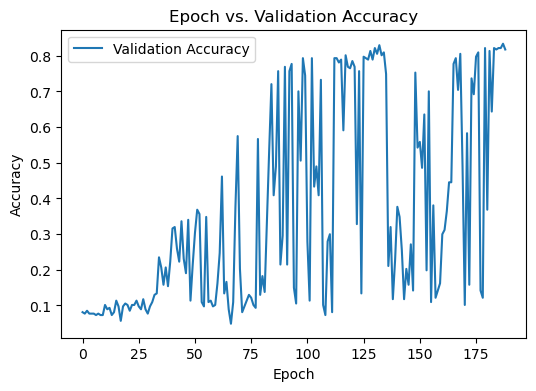

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Validation Accuracy')
plt.legend()
plt.show()


In [20]:
class_indices = np.argmax(y_train, axis=1)
class_names = np.unique(class_indices)

In [22]:
print(class_names)

[ 0  1  2  3  4  5  6  7  8  9 10]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


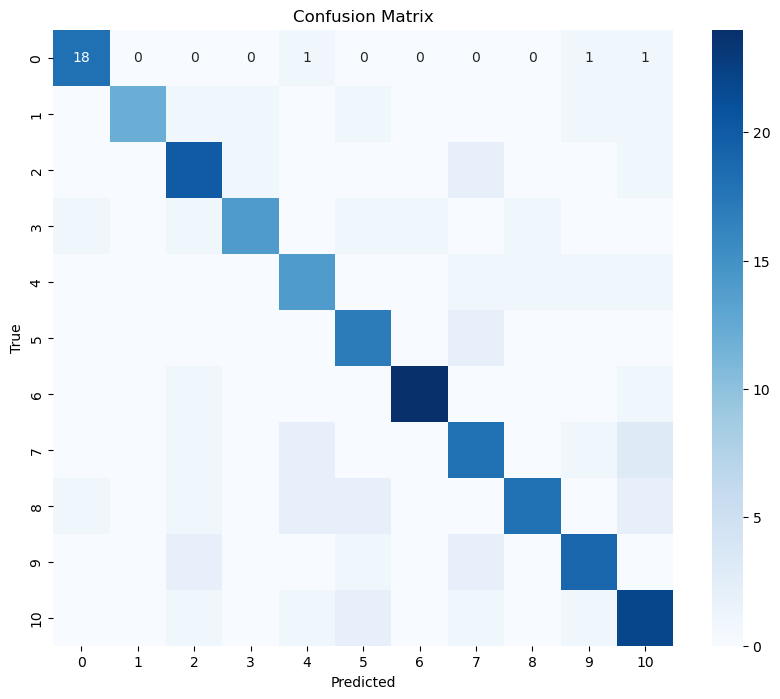

In [25]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(y_true_classes)

[ 2  8  2  3  2  9  6 10  4  8  6  8  9  8  9  5  8  9  8  3  0  3  5  9
  5  9  5  2  8  7  6  5  6  7  1 10  6  5 10  1  9  3  7  9  3  1  0  0
  3 10  0 10  0  7  9  4 10  6  4  4 10  1  0  2  2  0  4  1  0 10  2 10
  1  2  7  5  1  2  1  1  6  9  0  1  4  6  7  9  2  4  4  3  1 10  6  3
  0  6  9  8  7  3  5  8  8  9  7  8  6  8  7  8 10  8 10  8  4  9  2  8
 10  5  2  6  6  5  2  6  3  5  0  6  7  7  7  6  6  1  3  3  5 10 10  0
  7  2  2  4  8  8  2  5  6  6  5  7  0  4  0  2  0  2  4 10  1 10  5  6
  0  6  6  7  4  2  7  0  9  8 10 10 10  4  1 10  7  9  7  8  3  9  0  7
  7 10  9  8  5  5  6  3  2  7  9  1  8  9  8  2  7  6 10  8  7  2  9  6
  1 10 10  0  4 10  7  2  9  8  3  0  3  3  7  4  5  4  9  8  0  1  5  3
  4  6  2  3 10 10  9]


In [24]:
print(y_pred_classes)

[ 2  8  2  3  2  9  6  5  4  8  6  8  9  8  9  5  8  2  8  3  0  3  5  9
  5  9  7  2  8  4  6  7  2  2  1 10  6  5 10 10  9  6 10  9  3  1  0  0
  2 10  9  2  4  7  9  4 10 10  9  8 10  9  0  2  7  0  4  1  0 10  2 10
  5  2  4  5  2  2  1  1  6  9  0  1  4  6  7  9  2  4  4  3  1 10  6  3
  0  6  9 10  7  3  5  5  8  9  7  8  6  4  7  8 10  4 10  8  4  9  2  8
  9  5 10  6  6  5  2  6  0  5  0  6 10  7  7  6  6  1  3  8  5 10 10  0
  7  2  2 10  0  8  7  5  6  6  5  7  0  4 10  2  0  3  4 10  1 10  5  6
  0  6  6  7  4  2  7  0  9  5 10 10 10  4  1 10  7  9  7  8  3  2  0  7
  9 10  9  2  5  5  6  3  2  7  9  1  8  9  8  2  7  6  4  8  7  2  7  6
  1  7 10  0  4 10  7  2  9 10  3  0  5  3 10  4  5  7  7  8  0  3  5  3
  4  6  2  3 10  5  5]
